<a href="https://colab.research.google.com/github/tinayiluo0322/Neural-Network-Based-Large-Language-Models/blob/main/MNIST_Classification_Pytorch_MLP_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Data Classification

###### Luopeiwen Yi

In [14]:
import numpy as np
import struct
import os
import urllib.request
from google.colab import drive
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data import TensorDataset

# Mount Google Drive
#drive.mount('/content/drive')

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


Binary Classification 4 and 9

In [16]:
# Load the MNIST dataset without transformation (raw data)
raw_train_dataset = torchvision.datasets.MNIST(root="./mnist_data", train=True, download=True)
raw_test_dataset = torchvision.datasets.MNIST(root="./mnist_data", train=False, download=True)

# Function to filter only digits "4" and "9" before applying transformations
def filter_digits_raw(dataset, digit1=9, digit2=4):
    mask = (dataset.targets == digit1) | (dataset.targets == digit2)  # Filter digits 9 and 4
    filtered_images = dataset.data[mask].float()  # Keep raw values (0-255), normalization happens later
    filtered_labels = torch.where(dataset.targets[mask] == digit1, 0, 1)  # Binary labels (0 for '9', 1 for '4')
    return filtered_images, filtered_labels

# Filter datasets for digits 4 & 9 before transformation
train_images, train_labels = filter_digits_raw(raw_train_dataset)
test_images, test_labels = filter_digits_raw(raw_test_dataset)

# Compute mean & std from the training dataset
train_mean = train_images.mean().item() / 255.0  # Compute in [0,1] range
train_std = train_images.std().item() / 255.0
print(f"Computed Train Set Mean: {train_mean:.4f}, Train Set Std: {train_std:.4f}")

# Define final transformation using the computed mean & std
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to tensor, scales to [0, 1]
    transforms.Normalize((train_mean,), (train_std,))  # Apply computed train set stats
])

# Load the dataset with the correct transformation
train_dataset = torchvision.datasets.MNIST(root="./mnist_data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./mnist_data", train=False, transform=transform, download=True)

# Function to filter only digits "4" and "9" after applying transformations
def filter_digits(dataset, digit1=9, digit2=4):
    mask = (dataset.targets == digit1) | (dataset.targets == digit2)
    filtered_images = dataset.data[mask]  # No need to convert to float again, already normalized
    filtered_labels = torch.where(dataset.targets[mask] == digit1, 0, 1)
    return filtered_images, filtered_labels

# Filter the datasets again after applying the transformation
train_images, train_labels = filter_digits(train_dataset)
test_images, test_labels = filter_digits(test_dataset)

# Reshape images for ML models (Flatten 28x28 into 784)
train_images = train_images.view(train_images.shape[0], -1).to(device)
test_images = test_images.view(test_images.shape[0], -1).to(device)
train_labels = train_labels.to(device)
test_labels = test_labels.to(device)

# Print dataset shapes
print(f"Train set: {len(train_images)}, Labels: {len(train_labels)}")
print(f"Test set: {len(test_images)}, Labels: {len(test_labels)}")

Computed Train Set Mean: 0.1220, Train Set Std: 0.2981
Train set: 11791, Labels: 11791
Test set: 1991, Labels: 1991


Linear Regression Binary Classification

In [18]:
# Define the logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)  # Linear layer for w^T x + b

    def forward(self, x):
        return torch.sigmoid(self.linear(x))  # Apply sigmoid function

In [19]:
# Set training parameters
input_dim = 28 * 28  # MNIST images are 28x28 pixels
batch_size = 32
learning_rate = 0.0001
num_epochs = 25

In [ ]:
# Extract tensors from Subset objects and move to device
train_images_tensor = torch.stack([train_images[i] for i in range(len(train_images))]).to(device).float()
train_labels_tensor = torch.stack([train_labels[i] for i in range(len(train_labels))]).to(device)

test_images_tensor = torch.stack([test_images[i] for i in range(len(test_images))]).to(device).float()
test_labels_tensor = torch.stack([test_labels[i] for i in range(len(test_labels))]).to(device)

# Convert to TensorDataset
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor.unsqueeze(1).float())
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor.unsqueeze(1).float())

# Create DataLoaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
# Initialize model, loss function, and optimizer
model = LogisticRegression(input_dim).to(device)
criterion = nn.BCELoss().to(device)  # Binary Cross-Entropy Loss for classification
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_ims = 0
    total_batches = 0
    total_loss = 0
    total_corrects = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_ims += labels.shape[0]
        total_batches += 1
        total_loss += loss.item()
        total_corrects += ((outputs >= 0.5).float() == labels).sum().item()

        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx}: Loss = {loss.item():.4f}")

    avg_loss = total_loss / total_batches
    acc = (total_corrects / total_ims) * 100.0

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss:.4f}, Training Accuracy: {acc:.2f}%")

Batch 0: Loss = 28.8760
Batch 100: Loss = 0.9117
Batch 200: Loss = 0.0005
Batch 300: Loss = 0.0236
Epoch 1/25, Training Loss: 4.9127, Training Accuracy: 88.84%
Batch 0: Loss = 3.1885
Batch 100: Loss = 0.0012
Batch 200: Loss = 0.0696
Batch 300: Loss = 0.5887
Epoch 2/25, Training Loss: 1.5310, Training Accuracy: 95.24%
Batch 0: Loss = 13.7183
Batch 100: Loss = 0.7847
Batch 200: Loss = 0.0000
Batch 300: Loss = 0.1049
Epoch 3/25, Training Loss: 1.4360, Training Accuracy: 95.59%
Batch 0: Loss = 0.2507
Batch 100: Loss = 0.1798
Batch 200: Loss = 0.6808
Batch 300: Loss = 0.4906
Epoch 4/25, Training Loss: 1.3002, Training Accuracy: 95.79%
Batch 0: Loss = 3.6727
Batch 100: Loss = 0.0754
Batch 200: Loss = 0.3339
Batch 300: Loss = 3.6874
Epoch 5/25, Training Loss: 1.1242, Training Accuracy: 95.99%
Batch 0: Loss = 0.1164
Batch 100: Loss = 0.7612
Batch 200: Loss = 0.0014
Batch 300: Loss = 3.1250
Epoch 6/25, Training Loss: 1.0999, Training Accuracy: 96.16%
Batch 0: Loss = 0.2110
Batch 100: Loss = 3.1

In [21]:
# Function to evaluate the model on the test set
def test_model(model, test_loader, criterion, device):
    total_ims = 0
    total_batches = 0
    total_loss = 0
    total_corrects = 0

    # Put model in evaluation mode
    model.eval()

    # Do NOT compute gradients
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            # Move data to GPU
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)

            # Convert outputs to binary predictions
            predictions = (outputs >= 0.5).float()

            # Count correct predictions
            correct = (predictions == labels).sum().item()

            # Accumulate totals
            total_ims += labels.shape[0]
            total_batches += 1
            total_loss += loss.item()
            total_corrects += correct

    # Compute average loss and accuracy
    avg_loss = total_loss / total_batches
    acc = (total_corrects / total_ims) * 100.0

    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {acc:.2f}%")

# Call test function
test_model(model, test_loader, criterion, device)

Test Loss: 0.6724, Test Accuracy: 96.99%


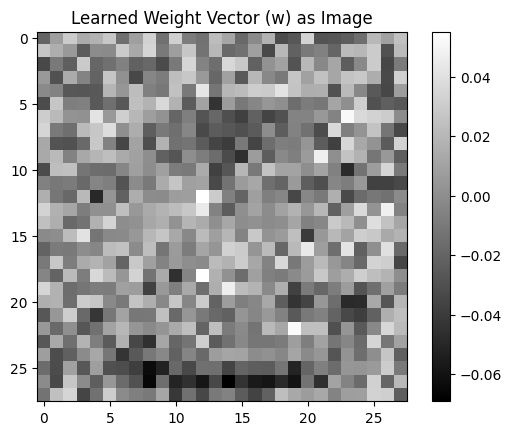

In [22]:
# Extract learned weights and reshape them into an image (28x28)
learned_weights = model.linear.weight[0].data.view(28, 28).cpu().numpy()

# Plot learned weights as an image
plt.imshow(learned_weights, cmap="gray")
plt.colorbar()
plt.title("Learned Weight Vector (w) as Image")
plt.show()

Multilayer Perceptron Binary Classification

In [23]:
# Define the Multilayer Perceptron model (MLP)
class MLP(nn.Module):
    def __init__(self, input_dim, d1, d2):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_dim, d1)  # First hidden layer
        self.hidden2 = nn.Linear(d1, d2)  # Second hidden layer
        self.output = nn.Linear(d2, 1)  # Output layer (single neuron for binary classification)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))  # Apply ReLU activation
        x = torch.relu(self.hidden2(x))  # Apply ReLU activation
        x = torch.sigmoid(self.output(x))  # Sigmoid for binary classification
        return x

In [24]:
# Define model parameters
input_dim = 28 * 28  # MNIST images are 28x28 pixels
d1 = 128  # First hidden layer size
d2 = 64   # Second hidden layer size
batch_size = 32
learning_rate = 0.0001
num_epochs = 50

In [25]:
# Initialize model, loss function, and optimizer
model = MLP(input_dim, d1, d2).to(device)
criterion = nn.BCELoss().to(device)  # Binary Cross-Entropy Loss for classification
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_ims = 0
    total_batches = 0
    total_loss = 0
    total_corrects = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_ims += labels.shape[0]
        total_batches += 1
        total_loss += loss.item()
        total_corrects += ((outputs >= 0.5).float() == labels).sum().item()

        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx}: Loss = {loss.item():.4f}")

    avg_loss = total_loss / total_batches
    acc = (total_corrects / total_ims) * 100.0

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss:.4f}, Training Accuracy: {acc:.2f}%")

Batch 0: Loss = 6.5505
Batch 100: Loss = 0.3988
Batch 200: Loss = 0.2170
Batch 300: Loss = 0.2814
Epoch 1/50, Training Loss: 0.3677, Training Accuracy: 87.56%
Batch 0: Loss = 0.0882
Batch 100: Loss = 0.1552
Batch 200: Loss = 0.2957
Batch 300: Loss = 0.0812
Epoch 2/50, Training Loss: 0.1427, Training Accuracy: 95.01%
Batch 0: Loss = 0.0918
Batch 100: Loss = 0.0811
Batch 200: Loss = 0.0171
Batch 300: Loss = 0.0628
Epoch 3/50, Training Loss: 0.1115, Training Accuracy: 96.00%
Batch 0: Loss = 0.0851
Batch 100: Loss = 0.0822
Batch 200: Loss = 0.0305
Batch 300: Loss = 0.1275
Epoch 4/50, Training Loss: 0.0940, Training Accuracy: 96.57%
Batch 0: Loss = 0.0488
Batch 100: Loss = 0.0427
Batch 200: Loss = 0.0064
Batch 300: Loss = 0.1068
Epoch 5/50, Training Loss: 0.0827, Training Accuracy: 96.99%
Batch 0: Loss = 0.0386
Batch 100: Loss = 0.0527
Batch 200: Loss = 0.1613
Batch 300: Loss = 0.0056
Epoch 6/50, Training Loss: 0.0742, Training Accuracy: 97.40%
Batch 0: Loss = 0.0369
Batch 100: Loss = 0.039

In [26]:
# Test function
def test_model(model, test_loader, criterion, device):
    total_ims = 0
    total_batches = 0
    total_loss = 0
    total_corrects = 0

    # Put model in evaluation mode
    model.eval()

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            predictions = (outputs >= 0.5).float()
            correct = (predictions == labels).sum().item()

            total_ims += labels.shape[0]
            total_batches += 1
            total_loss += loss.item()
            total_corrects += correct

    avg_loss = total_loss / total_batches
    acc = (total_corrects / total_ims) * 100.0

    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {acc:.2f}%")

# Evaluate on test set
test_model(model, test_loader, criterion, device)

Test Loss: 0.0404, Test Accuracy: 98.59%


Multilayer Perceptron 10 Class Classification

In [27]:
# Define the 10-Class MLP Model
class MLP_MultiClass(nn.Module):
    def __init__(self, input_dim, d1, d2, num_classes):
        super(MLP_MultiClass, self).__init__()
        self.hidden1 = nn.Linear(input_dim, d1)  # First hidden layer
        self.hidden2 = nn.Linear(d1, d2)  # Second hidden layer
        self.output = nn.Linear(d2, num_classes)  # Output layer with 10 neurons (one per class)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))  # Apply ReLU activation
        x = torch.relu(self.hidden2(x))  # Apply ReLU activation
        x = self.output(x)  # No softmax here, PyTorch's CrossEntropyLoss applies it automatically
        return x

In [28]:
# Define model parameters
input_dim = 28 * 28  # MNIST images are 28x28 pixels
d1 = 128  # First hidden layer size
d2 = 64   # Second hidden layer size
num_classes = 10  # Now we classify 10 digits (0-9)
batch_size = 32
learning_rate = 0.0001
num_epochs = 50

In [29]:
# Define preprocessing transformations (Normalize using dataset mean & std)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Standard MNIST normalization
])

# Load full MNIST dataset (No filtering, we now use all 10 digits)
train_dataset = torchvision.datasets.MNIST(root="./mnist_data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./mnist_data", train=False, transform=transform, download=True)

# Create DataLoaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [33]:
# print train and test dataset size
print(f"Train set: {len(train_dataset)}")
print(f"Test set: {len(test_dataset)}")

Train set: 60000
Test set: 10000


In [30]:
# Initialize model, loss function, and optimizer
model = MLP_MultiClass(input_dim, d1, d2, num_classes).to(device)
criterion = nn.CrossEntropyLoss().to(device)  # Cross-Entropy Loss for multi-class classification
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [31]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_corrects = 0
    total_samples = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Flatten images
        images = images.view(images.shape[0], -1)

        optimizer.zero_grad()
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        # Compute accuracy
        predictions = torch.argmax(outputs, dim=1)  # Get the predicted class
        correct = (predictions == labels).sum().item()

        total_loss += loss.item()
        total_corrects += correct
        total_samples += labels.shape[0]

        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx}: Loss = {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    acc = (total_corrects / total_samples) * 100.0

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss:.4f}, Training Accuracy: {acc:.2f}%")

Batch 0: Loss = 2.3467
Batch 100: Loss = 2.3194
Batch 200: Loss = 2.2943
Batch 300: Loss = 2.3041
Batch 400: Loss = 2.3034
Batch 500: Loss = 2.3189
Batch 600: Loss = 2.2815
Batch 700: Loss = 2.3265
Batch 800: Loss = 2.2776
Batch 900: Loss = 2.3102
Batch 1000: Loss = 2.2967
Batch 1100: Loss = 2.2894
Batch 1200: Loss = 2.2749
Batch 1300: Loss = 2.3049
Batch 1400: Loss = 2.2770
Batch 1500: Loss = 2.2859
Batch 1600: Loss = 2.2645
Batch 1700: Loss = 2.2973
Batch 1800: Loss = 2.2638
Epoch 1/50, Training Loss: 2.2974, Training Accuracy: 10.72%
Batch 0: Loss = 2.2873
Batch 100: Loss = 2.2752
Batch 200: Loss = 2.2543
Batch 300: Loss = 2.2589
Batch 400: Loss = 2.2827
Batch 500: Loss = 2.2715
Batch 600: Loss = 2.2453
Batch 700: Loss = 2.2151
Batch 800: Loss = 2.2536
Batch 900: Loss = 2.2600
Batch 1000: Loss = 2.2686
Batch 1100: Loss = 2.2610
Batch 1200: Loss = 2.2478
Batch 1300: Loss = 2.2671
Batch 1400: Loss = 2.2640
Batch 1500: Loss = 2.2488
Batch 1600: Loss = 2.2395
Batch 1700: Loss = 2.2332
B

In [32]:
# Test function
def test_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)

            # Flatten images
            images = images.view(images.shape[0], -1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            predictions = torch.argmax(outputs, dim=1)  # Get the predicted class
            correct = (predictions == labels).sum().item()

            total_loss += loss.item()
            total_corrects += correct
            total_samples += labels.shape[0]

    avg_loss = total_loss / len(test_loader)
    acc = (total_corrects / total_samples) * 100.0

    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {acc:.2f}%")

# Evaluate on test set
test_model(model, test_loader, criterion, device)

Test Loss: 0.3354, Test Accuracy: 90.55%


MLP with Skip Connections and Layer Normalization for 10 Class Classification

In [36]:
# Define the MLP model with skip connections between d1 and d2
class MLP_Skip_LN(nn.Module):
    def __init__(self, input_dim, d1, num_classes):
        super(MLP_Skip_LN, self).__init__()

        # Keep d1 = d2 for skip connection compatibility
        self.hidden1 = nn.Linear(input_dim, d1)
        self.hidden2 = nn.Linear(d1, d1)  # d1 = d2 (same size)

        self.ln1 = nn.LayerNorm(d1)  # LayerNorm AFTER activation
        self.ln2 = nn.LayerNorm(d1)  # LayerNorm AFTER activation

        self.output = nn.Linear(d1, num_classes)

    def forward(self, x):
        x1 = torch.relu(self.hidden1(x))  # First hidden layer activation
        x1 = self.ln1(x1)  # Apply LayerNorm AFTER activation

        x2 = torch.relu(self.hidden2(x1) + x1)  # Apply activation AFTER skip connection
        x2 = self.ln2(x2)  # Apply LayerNorm AFTER activation

        x = self.output(x2)  # Final classification layer
        return x

In [37]:
# Model parameters
input_dim = 28 * 28  # MNIST images are 28x28
d1 = 128  # Keep d1 = d2
num_classes = 10  # 10-class classification
batch_size = 32
learning_rate = 0.0001
num_epochs = 50

In [38]:
# Initialize model, loss function, and optimizer
model = MLP_Skip_LN(input_dim, d1, num_classes).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_corrects = 0
    total_samples = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        images = images.view(images.shape[0], -1)  # Flatten images

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        predictions = torch.argmax(outputs, dim=1)
        correct = (predictions == labels).sum().item()

        total_loss += loss.item()
        total_corrects += correct
        total_samples += labels.shape[0]

        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx}: Loss = {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    acc = (total_corrects / total_samples) * 100.0

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss:.4f}, Training Accuracy: {acc:.2f}%")

Batch 0: Loss = 2.5009
Batch 100: Loss = 2.2595
Batch 200: Loss = 2.2310
Batch 300: Loss = 1.9587
Batch 400: Loss = 1.8364
Batch 500: Loss = 1.8384
Batch 600: Loss = 1.6636
Batch 700: Loss = 1.5116
Batch 800: Loss = 1.5167
Batch 900: Loss = 1.4683
Batch 1000: Loss = 1.7266
Batch 1100: Loss = 1.2691
Batch 1200: Loss = 1.3220
Batch 1300: Loss = 1.2085
Batch 1400: Loss = 1.3784
Batch 1500: Loss = 1.1088
Batch 1600: Loss = 1.3543
Batch 1700: Loss = 1.0978
Batch 1800: Loss = 1.0065
Epoch 1/50, Training Loss: 1.5755, Training Accuracy: 55.44%
Batch 0: Loss = 1.1135
Batch 100: Loss = 0.9370
Batch 200: Loss = 1.0227
Batch 300: Loss = 1.1352
Batch 400: Loss = 0.9657
Batch 500: Loss = 1.1235
Batch 600: Loss = 1.0308
Batch 700: Loss = 0.9307
Batch 800: Loss = 0.9476
Batch 900: Loss = 0.9333
Batch 1000: Loss = 0.8630
Batch 1100: Loss = 0.9775
Batch 1200: Loss = 0.8438
Batch 1300: Loss = 0.7283
Batch 1400: Loss = 0.7531
Batch 1500: Loss = 0.7281
Batch 1600: Loss = 0.8864
Batch 1700: Loss = 0.8079
B

In [39]:
# Testing function
def test_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            images = images.view(images.shape[0], -1)  # Flatten images

            outputs = model(images)
            loss = criterion(outputs, labels)

            predictions = torch.argmax(outputs, dim=1)
            correct = (predictions == labels).sum().item()

            total_loss += loss.item()
            total_corrects += correct
            total_samples += labels.shape[0]

    avg_loss = total_loss / len(test_loader)
    acc = (total_corrects / total_samples) * 100.0

    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {acc:.2f}%")

# Evaluate on test set
test_model(model, test_loader, criterion, device)

Test Loss: 0.1775, Test Accuracy: 94.95%
